# Temporal Visualization

Python 3.5

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys, imp
import numpy as np
import pandas as pd
import re
import random
import nltk
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()
import string
import datetime
import imp

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
punctuation = set(string.punctuation)

In [3]:
os.chdir('..') # Change to Top Level GIT Directory

In [4]:
pwd

'/Users/hopeemac/Documents/Code/GIT/DSI_Religion'

In [5]:
sys.path.append('./prototype_python') # Add location of python prototype to path

In [6]:
sys.path.append('./protest_temporalAnalysis/') # Add location of python prototype to path

In [7]:
import temporal_methods as tm
import fileData_load_functions as lf # Import Functions to Get Metadata from File Names
import semanticDensity as sd
import syntacticParsing as sp

## -- Set up Parameters for Analysis --

group = 'DorothyDay'
plotstart = '1933-01-01'
plotend = '1981-01-01'
plotfilename = 'DorothyDay_temporal.pdf'
saveplot = True

group = 'WBC'
plotstart = '2007-01-01'
plotend = '2016-01-01'
plotfilename = 'WBC_temporal.pdf'
saveplot = True

In [8]:
group = 'MLK'
plotstart = '1954-01-01'
plotend = '1969-01-01'
plotfilename = 'MLK_temporal.pdf'
saveplot = True

group = 'Ghandi'
plotstart = '1915-01-01'
plotend = '1949-01-01'
plotfilename = 'Ghandi_temporal.pdf'
saveplot = True

### Read in Sample of News Articles

In [9]:
articleLoc = '/Volumes/Seagate Backup Plus Drive/NYT_GerberSample/news_documents.xml'

In [10]:
data = tm.parse_xml(articleLoc, 'doc', ['id','t','d','c'])

In [11]:
data.columns = ['id','title','date','content']

In [12]:
# Tokenize and Clean News Articles
newsTokenLists = {data.loc[rowID,'id']: tokenizer.tokenize(data.loc[rowID,'content']) for rowID in range(0,len(data))}
newsTokenLists = {data.loc[rowID,'id']: tm.clean_text(newsTokenLists[data.loc[rowID,'id']]) for rowID in range(0,len(data))}

### Build Metadata File for Analysis Text

In [13]:
if group == 'DorothyDay':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/DorothyDay/raw/'
    fileData = lf.getDorothyDaymetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1933-05-01 00:00:00 1980-10-01 00:00:00

In [14]:
if group == 'WBC':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/data_dsicap/WBC/raw/'
    fileData = lf.getWBCmetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 2007-05-27 00:00:00 2015-09-20 00:00:00

In [15]:
if group == 'MLK':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/MLK/raw/'
    fileData = lf.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1954-02-28 00:00:00 1968-03-31 00:00:00

1954-02-28 00:00:00 1968-03-31 00:00:00


In [16]:
if group == 'Ghandi':
    dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/Ghandi/raw/'
    fileData = lf.getSimplemetadata(dataloc)
    print(fileData.date_clean.min(), fileData.date_clean.max())
    # 1915-04-21 00:00:00 1948-01-12 00:00:00

In [17]:
tokenLists = {file: tm.tokenize34(dataloc,file) for file in fileData.fileName}
tokenLists = {file: tm.clean_text(tokenLists[file]) for file in fileData.fileName}

In [18]:
shortfiles = []
for i in range(len(fileData)):
    if len(set(tokenLists[fileData.loc[i,'fileName']])) < 100:
        # print('problem'+file)
        shortfiles.append(i)
print(shortfiles)

[]


In [19]:
fileData.drop(shortfiles, inplace=True)

### Set up Protest Data (Random for now)

In [20]:
# numprotests = int(round(len(fileData)*0.2,0))
# protests = ([1]*numprotests + [0]*(len(fileData)-numprotests))

In [21]:
# random.shuffle(protests)

In [22]:
# fileData['protest'] = protests

In [23]:
pwd

'/Users/hopeemac/Documents/Code/GIT/DSI_Religion'

In [24]:
dates = pd.read_excel('./protest_temporalAnalysis/CivilRightsMovement_Dates.xlsx')

In [25]:
d = dates[dates.Type == 'Death']

### Document Level - Word Count Signals

In [26]:
counts = [tm.count_words(tokenLists[file]) for file in fileData.fileName]
fileData['wordcount'] = counts

In [27]:
protest = [tm.count_specific_words(tokenLists[file], 'protest') for file in fileData.fileName]

In [28]:
god = [tm.count_specific_words(tokenLists[file], 'god') for file in fileData.fileName]

In [29]:
fileData['wordcount'] = counts

In [30]:
fileData['protest_word'] = protest

In [31]:
fileData['god'] = god

### Document Level - Semantic Density Signal w/ News

Updates to context vector semantic density algorithm for document level analysis: 
- create DSM from external source (i.e. set of news articles) instead of bin being analyzed
- context vectors made occurance of target word in single document with distribution from generic DSM
- updated algo to not make/store context vectors unless in target word list
- had to account for words in the document, but not in the DSM (smoothing) * not complete, now returns all 0's
- updated algo to return # of times target words shows up in the document, to help check for bias in small # of occurences of search word in document
- 

In [32]:
#Get word coCo for News Articles
CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)
#Get DSM for News Articles
DSM=sd.DSM(CoCo,100)

In [33]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    CVDict=tm.contextVectors(tokenLists[file], DSM, ['the'], 2)
    cosineSimilarity=tm.averageCosine(CVDict,simCount=10000)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [34]:
fileData['semanticDensity_the'] = semanticDensity

In [35]:
targetwords = {}
for file in fileData.fileName:
    targetwords[file] = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)

./prototype_python/syntacticParsing.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  targetDF.sort(['count'],inplace=True,ascending=False)


In [36]:
semanticDensity=[]
for file in fileData.fileName:
    print(file)
    # targetwords = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)
    CVDict=tm.contextVectors(tokenLists[file], DSM, targetwords[file], 2)
    cosineSimilarity=tm.averageCosine(CVDict,simCount=10000)
    avgSD=np.mean([x[1] for x in cosineSimilarity])
    semanticDensity = semanticDensity+[avgSD]

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [37]:
fileData['semanticDensity_adjadv'] = semanticDensity

### Document-Level Sentiment

Updates to Sentiment algorithm for document level analysis: 
- % pos/neg words by document instead of averaged over bin
- don't have signal of % pos/neg documents per bin bc not relevant to single-document analysis

In [38]:
start=datetime.datetime.now()
sentiment=[]
for file in fileData.fileName:
    print(file)
    sent = tm.sentimentLookup(tokenLists[file])
    sentiment.append(sent) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [39]:
s=[sent[0][0] for sent in sentiment]
fileData['sentiment_pos']=s

In [40]:
s=[sent[0][1] for sent in sentiment]
fileData['sentiment_neg']=s

### Document-Level Network Analysis

Updates to network algorithm for document level analysis: 
- Using Top 10 (or less) Adj/Adv from the Single Document for analysis (maybe should switch this?)

In [41]:
import pandas as pd
import numpy as np

import igraph
import scipy.spatial.distance as ssd

import math

In [42]:
#Define functions
def getNetworkQuant(dsm,targetWords,netAngle):
    
    #Get list of values in DSM
    dsmList=[list(dsm[key].values()) for key in dsm.keys()]
    # print(dsmList)
    #Calculate distances for each set of values in dsm
    cosineNP=ssd.cdist(dsmList,dsmList,metric='cosine')
    
    adj = cosineNP.copy()
    
    #Apply thresholds
    adj[np.abs(cosineNP) >= math.cos(math.radians(netAngle))] = 0 # Converting 30 degree threshold to radians to a cosine value
    
    adj[np.abs(cosineNP) < math.cos(math.radians(netAngle))] = 1 # Converting 30 degree threshold to radians to a cosine value
    
    adjList = pd.DataFrame(adj,columns=dsm.keys(),index=dsm.keys()).values.tolist()
    
    #Create network graph
    net = igraph.Graph.Adjacency(adjList, mode = "undirected")
    
    #Get eigenvector centrality
    ev_centrality = igraph.Graph.evcent(net)
    
    # ** Double Check this Subseting ** #
    #Get mean eigenvector centrality for words in target list
    meanEVC=np.mean([ev_centrality[i] for i in range(len(dsm.keys())) if list(dsm.keys())[i] in targetWords])
    return(meanEVC)

In [43]:
# Make DSM from Document
# Still need to get Target Words
network=[]
for file in fileData.fileName:
    print(file)
    #Get word coCo for Single Document
    CoCo, TF, docTF = sd.coOccurence({file: tokenLists[file]},k=2)
    #Get DSM for Single Document
    DSM=sd.DSM(CoCo,100)
    # txtstr = getRawText(dataloc,fileData.fileName[0])
    # targetwords = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)
    # print(targetwords)
    result=getNetworkQuant(DSM,targetwords[file],30)
    network.append(result)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [44]:
fileData['network']=network

### Document-Level Subgraph Centrality

#### Warning: This metric not accurate/complete

In [45]:
import igraph
import scipy.spatial.distance as ssd
import math

In [46]:
#Define functions
def getSubgraphCent(dsm,targetwords,netAngle):
    # Get index location of Target Word, will match the vertex in the graph
    targetindex = []
    for word in targetwords:
        targetindex.append(list(dsm.keys()).index(word))
    
    #Get list of values in DSM
    dsmList=[list(dsm[key].values()) for key in dsm.keys()]
    # print(dsmList)
    #Calculate distances for each set of values in dsm
    cosineNP=ssd.cdist(dsmList,dsmList,metric='cosine')
    
    adj = cosineNP.copy()
    
    #Apply thresholds
    adj[np.abs(cosineNP) >= math.cos(math.radians(netAngle))] = 0 # Converting 30 degree threshold to radians to a cosine value
    
    adj[np.abs(cosineNP) < math.cos(math.radians(netAngle))] = 1 # Converting 30 degree threshold to radians to a cosine value
    
    adjList = pd.DataFrame(adj,columns=dsm.keys(),index=dsm.keys()).values.tolist()
    
    #Create network graph
    graph = igraph.Graph.Adjacency(adjList, mode = "undirected")
    
    # Get measure of the centrality of the subgraph containing only the target words
    subgraph = igraph.Graph.subgraph(graph, targetindex)
    centrality = sum(subgraph.betweenness()) / len(targetindex)

    return(centrality)

### Document-Level Judgements

Updates to Judgements algorithm for document level analysis: 
- get target words from single document, not from all documents in bin
- percent of judgements is based on a 1 document, not the average of all documents in bin
- only using % judgements, not raw count of number of judgement sentences

In [47]:
import syntacticParsing as sp

In [48]:
judgements=[]
for file in fileData.fileName:
    print(file)
    rawText = tm.getRawText(dataloc,file)
    targetwords = sp.targetWords(rawText,wordCount=10,startCount=0)
    percent=sp.judgements(rawText)
    judgements.append(percent)
    #judgementAvg=list(np.mean(np.array(judgementList),axis=0))

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt


./prototype_python/syntacticParsing.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  targetDF.sort(['count'],inplace=True,ascending=False)


4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Through a Great Revolution_National Cathedral, Washington, DC.t

In [49]:
j=[judge[1] for judge in judgements]
fileData['judgements']=j

### Visualizations

In [50]:
d.Date

0    1955-08-28
3    1963-06-11
5    1963-09-15
7    1963-06-12
9    1965-02-26
10   1965-03-09
Name: Date, dtype: datetime64[ns]

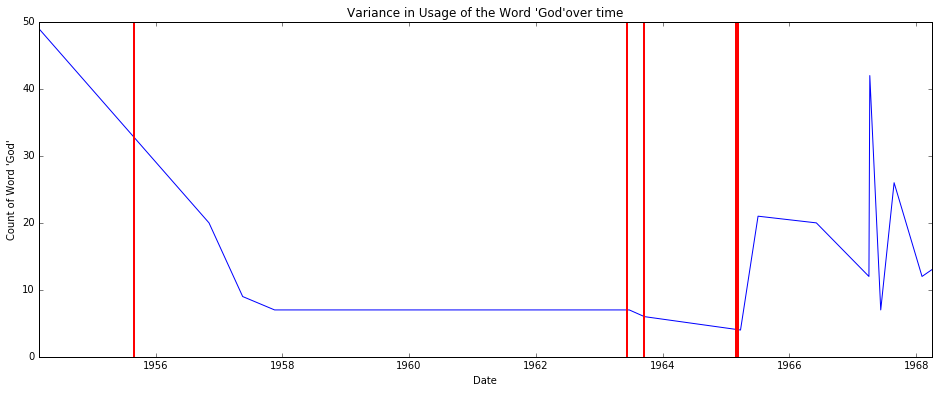

In [51]:
# Plotting the Count of the word 'God'
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.god)
[plt.axvline(event, color = 'red', lw=2) for event in d.Date]
#for event in d.Date:
#    print(event)
# plt.plot(d.Date, [10]*len(d),'*',ms=20)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
# plt.axvline(d.Date, color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.protest_word)
# plt.plot(fileData.date_clean, fileData.wordcount)
plt.ylabel("Count of Word 'Protest'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'Protest'over time")
plt.ylim([0,10])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.semanticDensity)
# plt.plot(fileData.date_clean, fileData.semanticDensity, 'ro') # Plot Points instead of Line
plt.ylabel("Semantic Density of the word 'the'")
plt.xlabel("Date")
plt.title("Semantic Density of the word 'the'")
plt.ylim([0.2,0.6])
plt.xlim(['2007-07-01','2008-07-01'])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

# Plot Network Signal over Time
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.network)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
#plt.axhline(fileData.god.mean(), color = 'green')
# plt.xlim(['2007-07-01','2008-07-01'])
plt.show()

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.judgements)
# plt.plot(fileData.date_clean, fileData.semanticDensity)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("% Judgements over Time")
#plt.axhline(fileData.god.mean(), color = 'green')
plt.xlim(['2012-01-01','2014-01-01'])
plt.show()

# Plotting w/ 2 Y-Scales
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(111)
ax1.plot(fileData.date_clean, fileData.semanticDensity)
ax1.set_xlabel('date')
ax1.set_ylabel('semantic density')
ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(fileData.date_clean, fileData.god, 'green')
ax2.set_ylabel('word count')

plt.show()

In [52]:
# Par Plot for all Signals in DF
def drawSignalPlots(fileData, start_date, end_date, filename, events, save):
    print(fileData.date_clean.min(), fileData.date_clean.max())
    signals = [var for var in fileData.columns if var not in ['fileName', 'date', 'date_clean']]

    plt.figure(num=None, figsize=(16, 4*len(signals)), dpi=80, facecolor='w', edgecolor='k')

    i = 1
    for signal in signals:
        plt.subplot(len(signals), 1, i)
        plt.plot(fileData.date_clean, fileData[signal], 'o')
        # [plt.axvline(event, color = 'red', lw=2) for event in d.Date]
        [plt.axvline(e, color = 'red', lw=2) for e in events]
        # plt.plot(fileData.date_clean, fileData.semanticDensity)
        plt.ylabel(signal)
        plt.xlabel("Date")
        if i == 1:
            plt.title(group+' Text Analysis')
        #plt.axhline(fileData.god.mean(), color = 'green')
        plt.axhspan(fileData[signal].quantile(0.25), fileData[signal].quantile(0.75), \
            facecolor='yellow', alpha=0.5)
        plt.xlim([start_date,end_date])
        i += 1
    if save:
        plt.savefig('./protest_temporalAnalysis/'+filename)
    plt.show()

### Draw Plots

1954-02-28 00:00:00 1968-03-31 00:00:00


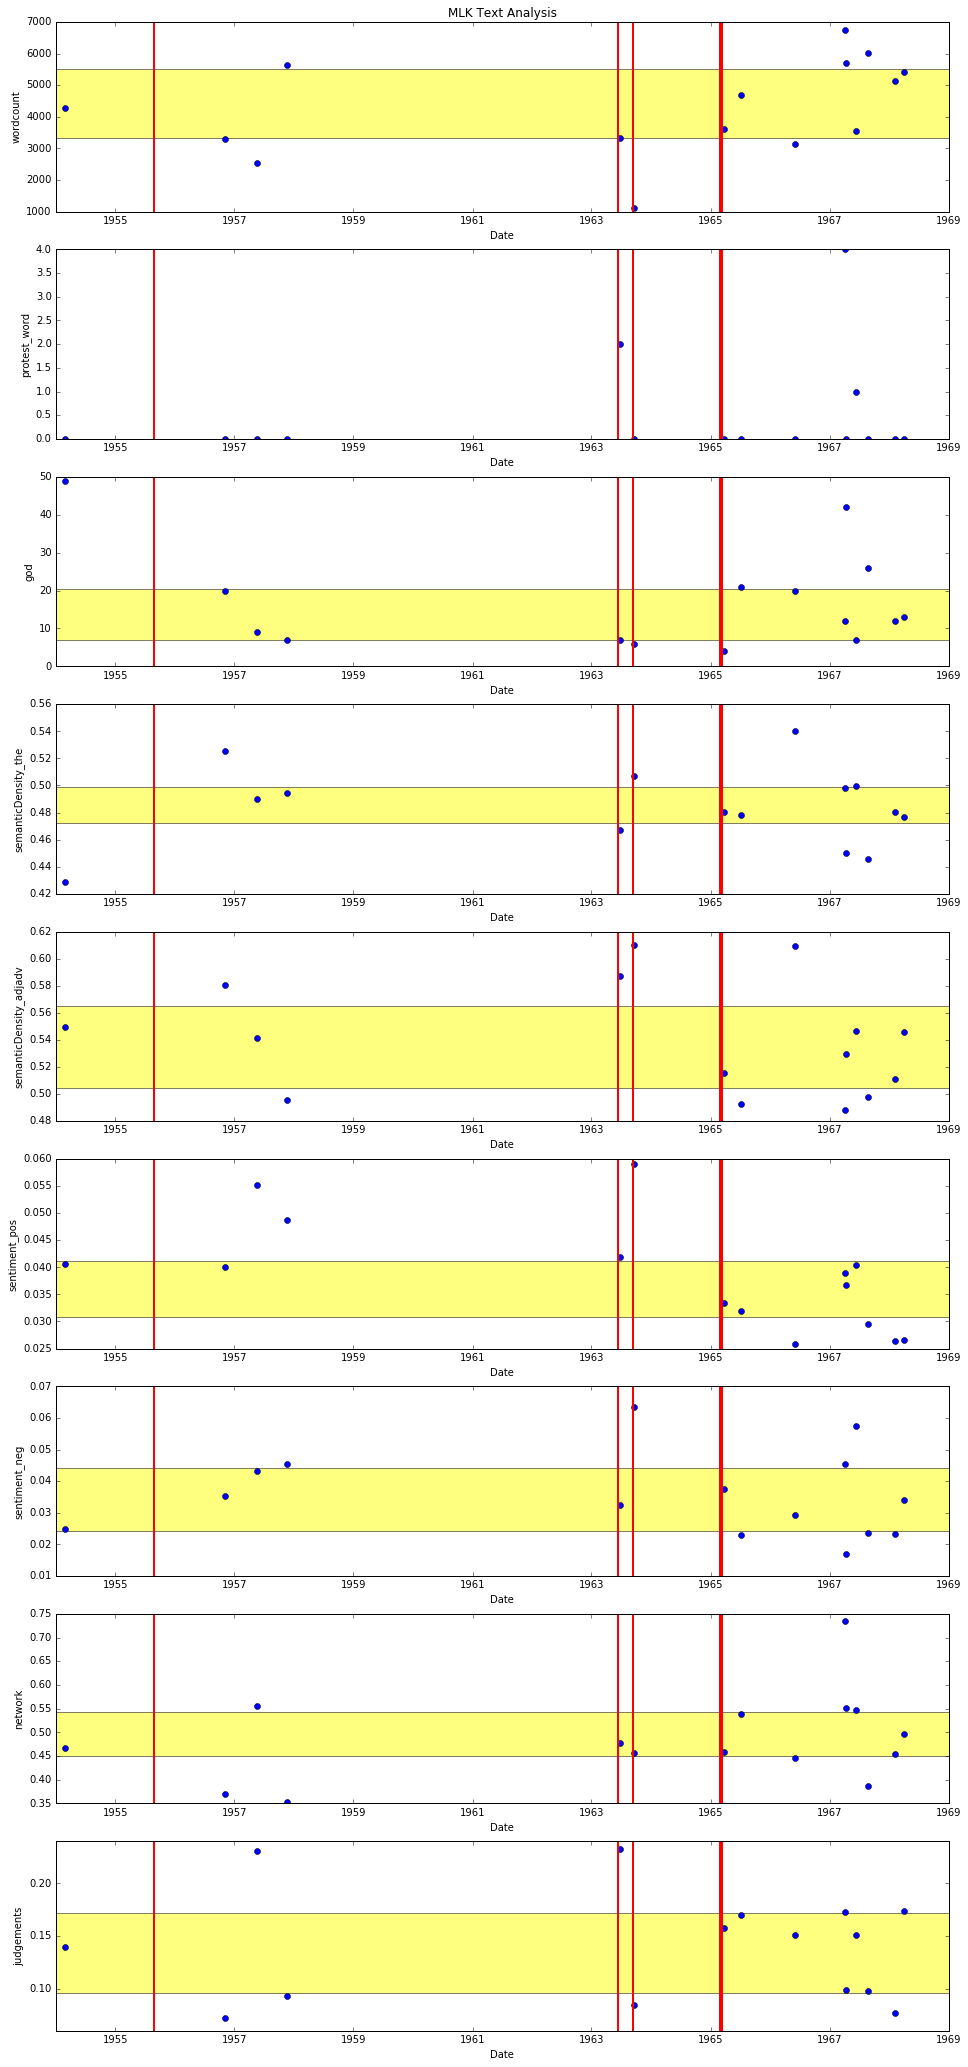

In [53]:
drawSignalPlots(fileData,plotstart,plotend,plotfilename,d.Date,saveplot)

In [54]:
os.system('say "your program has finished"')

0

In [55]:
from sklearn import preprocessing

In [56]:
min_max_scaler = preprocessing.MinMaxScaler()

In [57]:
# Par Plot for all Signals in DF
def drawStdSignalPlots(fileData, signals, start_date, end_date, filename, events, save):
    
    signals = [var for var in signals if var not in ['fileName', 'date', 'date_clean']]

    # Standardize the Signals
    fd_normalized = fileData[['fileName','date_clean']]
    for signal in signals:
        fd_normalized[signal] = min_max_scaler.fit_transform(fileData[signal])  
    
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

    i = 1
    for signal in signals:
        # plt.subplot(len(signals), 1, i)
        plt.plot(fd_normalized.date_clean, fd_normalized[signal], '-', marker='o')
        # [plt.axvline(event, color = 'red', lw=2) for event in d.Date]
        [plt.axvline(e, color = 'red', lw=2) for e in events]
        # plt.plot(fd_normalized.date_clean, fd_normalized.semanticDensity)
        plt.ylabel('Normalized Signal')
        plt.xlabel("Date")
        if i == 1:
            plt.title(group+' Text Analysis')
        #plt.axhline(fd_normalized.god.mean(), color = 'green')
        # plt.axhspan(fd_normalized[signal].quantile(0.25), fd_normalized[signal].quantile(0.75), \
        #     facecolor='yellow', alpha=0.5)
        plt.xlim([start_date,end_date])
        i += 1
        plt.legend(loc='best', fancybox=True, framealpha=0.5)
    if save:
        plt.savefig('./protest_temporalAnalysis/'+filename)
    plt.show()
    
    return fd_normalized

/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

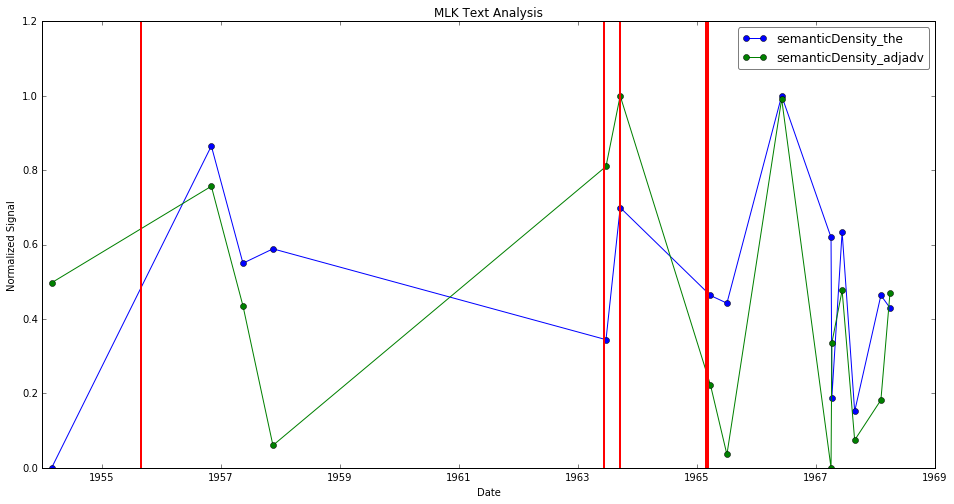

In [58]:
fd_normalized = drawStdSignalPlots(fileData,['semanticDensity_the','semanticDensity_adjadv'],plotstart,plotend,'std_semanticDensity_MLK.pdf',d.Date,True)

In [59]:
fd_normalized['diff'] = fd_normalized['semanticDensity_adjadv']-fd_normalized['semanticDensity_the']

/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
start_date = plotstart
end_date = plotend
events = d.Date

In [65]:
dates

,Event,Date,Source,Type
0,"14 year old Emmett Till is beaten, shot and ly...",1955-08-28,http://www.civilrights.org/resources/civilrigh...,Death
1,Rosa Parks refuses to up her bus seat to a wh...,1955-12-01,http://www.civilrights.org/resources/civilrigh...,Protest
2,federal troops mobilize to protect the nine Af...,1957-09-24,http://www.civilrights.org/resources/civilrigh...,Political
3,Medgar Evers murdered,1963-06-11,http://faculty.polytechnic.org/gfeldmeth/chart...,Death
4,March on Washington,1963-08-28,NaN,Protest
5,Birmingham church is bombed,1963-09-15,http://www.civilrights.org/resources/civilrigh...,Death
6,Lunch counter sit-in by four college students ...,1960-02-01,http://www.civilrights.org/resources/civilrigh...,Protest
7,"Medger Evers, NAACP field secretary in Jackson...",1963-06-12,http://www.civilrights.org/resources/civilrigh...,Death
8,"First Selma march, ""Bloody Sunday""",1965-03-07,https://en.wikipedia.org/wiki/Selma_to_Montgom...,Protest
9,activist and deaconJimmie Lee Jackson died aft...,1965-02-26,https://en.wikipedia.org/wiki/Selma_to_Montgom...,Death


In [69]:
d = dates[dates.Type == 'Death']

In [70]:
p = dates[dates.Type == 'Protest']

In [73]:
p

,Event,Date,Source,Type
1,Rosa Parks refuses to up her bus seat to a wh...,1955-12-01,http://www.civilrights.org/resources/civilrigh...,Protest
4,March on Washington,1963-08-28,NaN,Protest
6,Lunch counter sit-in by four college students ...,1960-02-01,http://www.civilrights.org/resources/civilrigh...,Protest
8,"First Selma march, ""Bloody Sunday""",1965-03-07,https://en.wikipedia.org/wiki/Selma_to_Montgom...,Protest
11,Selma March (3rd),1965-03-21,https://en.wikipedia.org/wiki/Selma_to_Montgom...,Protest


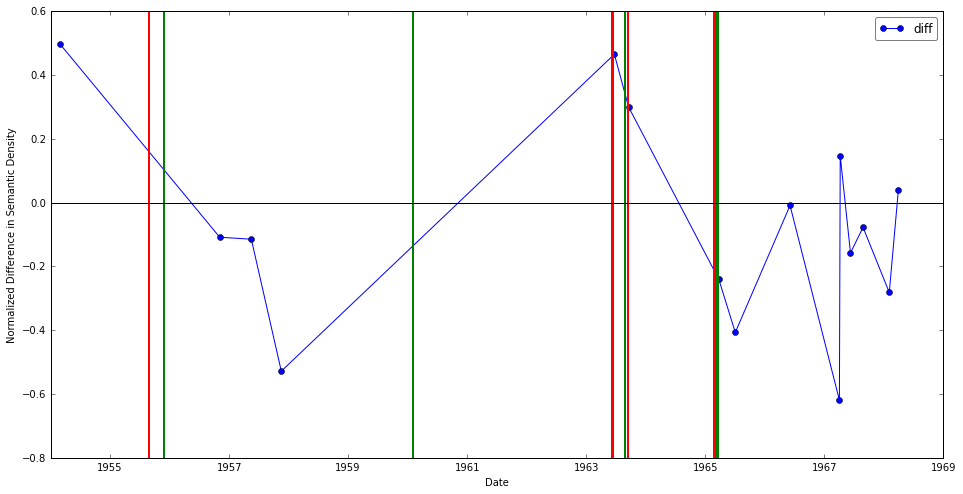

In [78]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fd_normalized.date_clean, fd_normalized['diff'], '-', marker='o')
# [plt.axvline(event, color = 'red', lw=2) for event in d.Date]
[plt.axvline(date, color = 'red', lw=2) for date in d.Date]
[plt.axvline(protest, color = 'green', lw=2) for protest in p.Date]
# plt.plot(fd_normalized.date_clean, fd_normalized.semanticDensity)
plt.ylabel('Normalized Difference in Semantic Density')
plt.xlabel("Date")
plt.axhline(0, color = 'black')
# plt.axhspan(fd_normalized[signal].quantile(0.25), fd_normalized[signal].quantile(0.75), \
#     facecolor='yellow', alpha=0.5)
plt.xlim([start_date,end_date])
i += 1
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.savefig('./protest_temporalAnalysis/semantic_difference.pdf')

/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/envs/rel35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, Deprecat

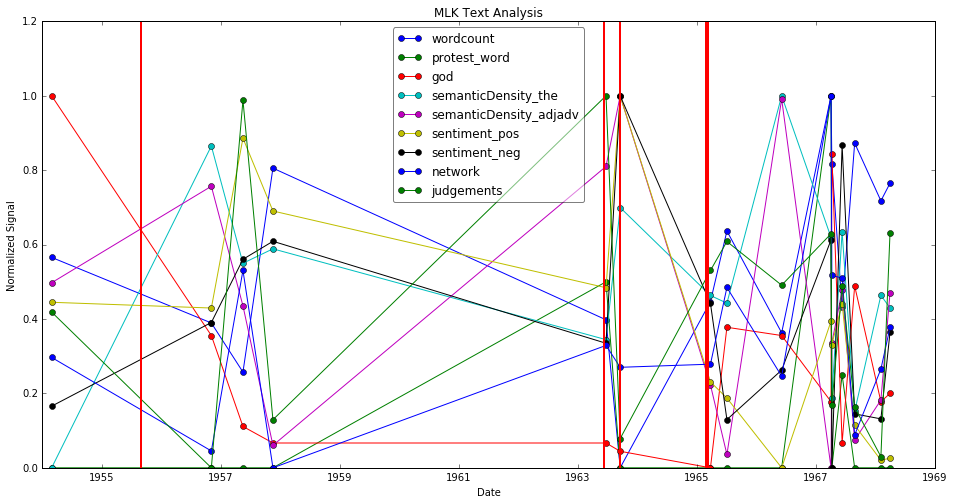

,fileName,date_clean,wordcount,protest_word,god,semanticDensity_the,semanticDensity_adjadv,sentiment_pos,sentiment_neg,network,judgements
7,28 February 1954_Rediscovering Lost Values_Det...,1954-02-28,0.565572,0.00,1.000000,0.000000,0.497472,0.444948,0.165669,0.296649,0.418639
12,4 November 1956_Paul's Letter to American Chri...,1956-11-04,0.389352,0.00,0.355556,0.865055,0.756824,0.429500,0.390591,0.045318,0.000000
1,"17 May 1957_Give Us the Ballot_Washington, D.C...",1957-05-17,0.257320,0.00,0.111111,0.549883,0.435413,0.886104,0.560451,0.530659,0.987950
2,17 November 1957_Loving Your Enemies.txt,1957-11-17,0.805501,0.00,0.066667,0.588614,0.060294,0.690320,0.608929,0.000000,0.129298
4,23 June 1963_Speech at the Great March on Detr...,1963-06-23,0.397870,0.50,0.066667,0.344515,0.810108,0.484043,0.334834,0.328966,1.000000
3,18 September 1963_Eulogy for the Martyred Chil...,1963-09-18,0.000000,0.00,0.044444,0.699560,1.000000,1.000000,1.000000,0.270142,0.078650
5,25 March 1965_Our God is Marching On!_Montgome...,1965-03-25,0.446673,0.00,0.000000,0.463183,0.222700,0.230922,0.441724,0.278561,0.530472
11,4 July 1965_The American Dream_Ebenezer Baptis...,1965-07-04,0.636557,0.00,0.377778,0.442604,0.035758,0.187434,0.129572,0.484801,0.608360
13,5 June 1966_Guidelines for a Constructive Chur...,1966-06-05,0.362910,0.00,0.355556,1.000000,0.991356,0.000000,0.262736,0.246252,0.490868
9,"4 April 1967_Beyond Vietnam_New York, N.Y.txt",1967-04-04,1.000000,1.00,0.177778,0.619315,0.000000,0.394354,0.612889,1.000000,0.629118


In [75]:
drawStdSignalPlots(fileData,fileData.columns,plotstart,plotend,'std_all_MLK.pdf',d.Date,True)